In [31]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [32]:
# reading in the dataset
df = pd.read_excel("AmesHousing.xlsx")

In [33]:
# observing the number of rows and columns
df.shape

(2930, 82)

In [34]:
# observing data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [35]:
# Initializing lists to store continuous and categorical features
cat_var = []
cont_var = []

# Appending to the lists depending on data type
for i in range(0,df.shape[1]):
    if df.iloc[:,i].dtype == 'float64' or df.iloc[:,i].dtype == 'int64':
        cont_var.append(df.columns[i])
    else:
        cat_var.append(df.columns[i])  

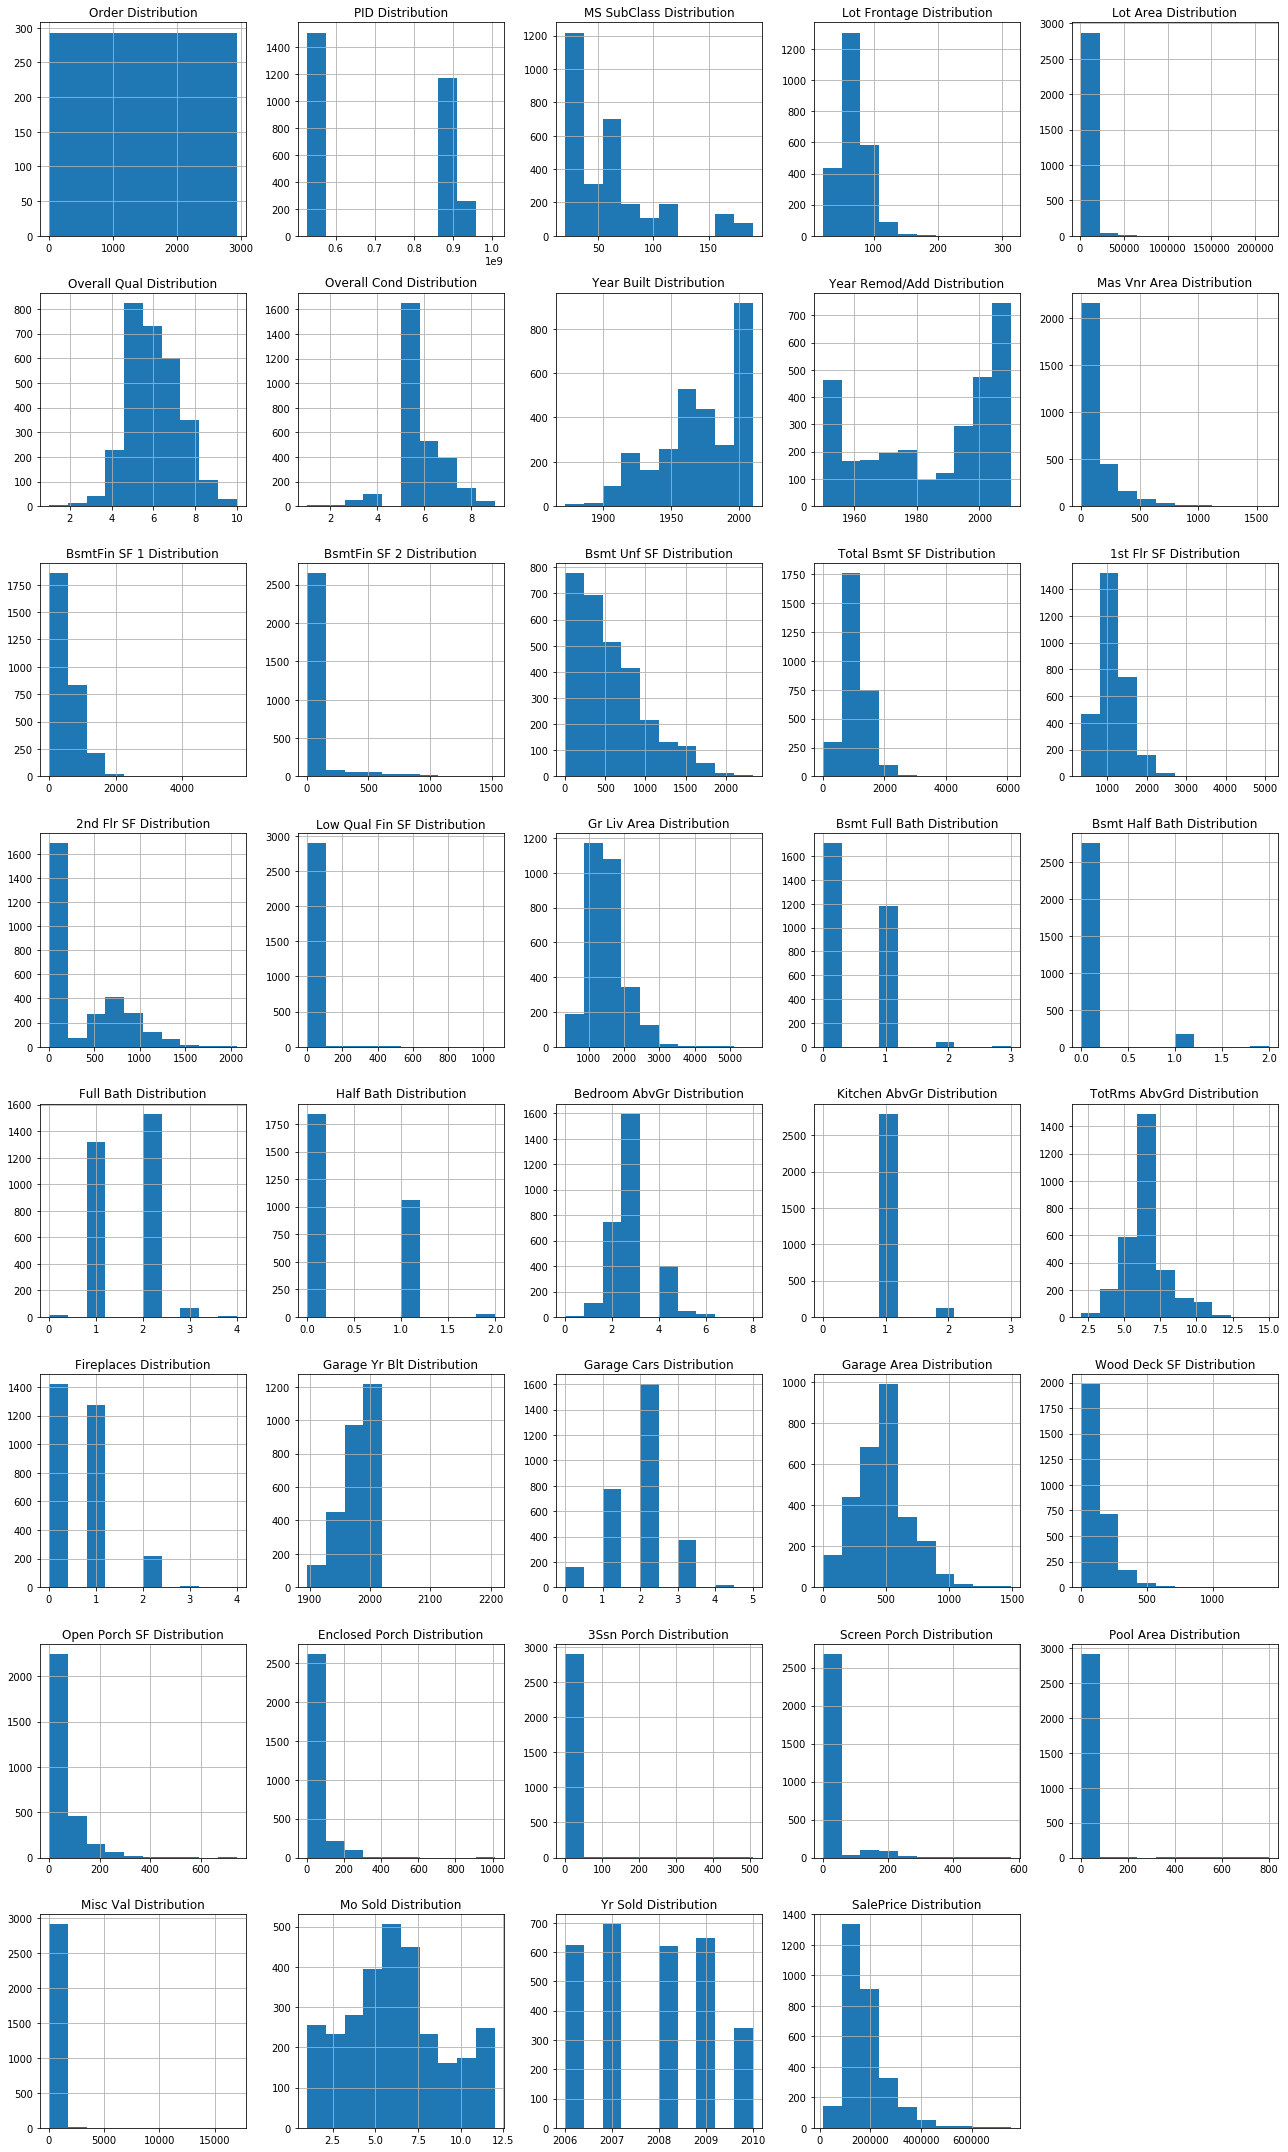

In [36]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,30))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()
    plt.show()

draw_histograms(df.loc[:,cont_var],df.loc[:,cont_var].columns,8,5)

### Observations
 - Taking all the features that have data type int64 and float64, we observe that not all of them behave as continuous features
 - Order is unique per record and hence is observed to have a uniform distrubution, while pid is an identifier and does not give any information about the record beyond identification
 - MS Subclass is code for a categorical variable and thus does not have numerical significance
 - Overall Cond and Overall Qual are ordinal variables which we will convert to categorical
 - Attributes such as Year Remod/Add, Year Built, Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, TotRms AbvGrd, Fireplaces, Garage Yr Blt, Garage Cars, Mo Sold and Yr Sold have discrete properties and we must decide whether to model them as categorical or continuous features

In [37]:
# converting non-continuous features to object data type
non_cont_var = ['Order', 'PID', 'MS SubClass', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
                'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Year Remod/Add', 'Overall Qual',
                'Overall Cond', 'Year Built', 'Mo Sold', 'Yr Sold']

# updating the continuous and categorical lists
for i in range(0,len(non_cont_var)):
    df.loc[:,non_cont_var[i]] = df.loc[:,non_cont_var[i]].astype(object)
    cat_var.append(non_cont_var[i])
    if non_cont_var[i] in cont_var: cont_var.remove(non_cont_var[i])
        
# updating continuous list to separate the target variable
if 'SalePrice' in cont_var: cont_var.remove('SalePrice')


In [38]:
# creating list for features with NA as valid category
cat_na_var = ['Alley','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Fireplace Qu','Garage Type',
              'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature']

# imputing the missing in these columns to NA
cat_na_imp = SimpleImputer(strategy='constant', fill_value='NA')
cat_na_imp.fit(df.loc[:,cat_na_var])
df.loc[:,cat_na_var] = cat_na_imp.transform(df.loc[:,cat_na_var])

# imputing all categorical and continuous columns
cat_imp = SimpleImputer(strategy='most_frequent')
cat_imp.fit(df.loc[:,cat_var])
df.loc[:,cat_var] = cat_imp.transform(df.loc[:,cat_var])

cont_imp = SimpleImputer(strategy='median')
cont_imp.fit(df.loc[:,cont_var])
df.loc[:,cont_var] = cont_imp.transform(df.loc[:,cont_var])

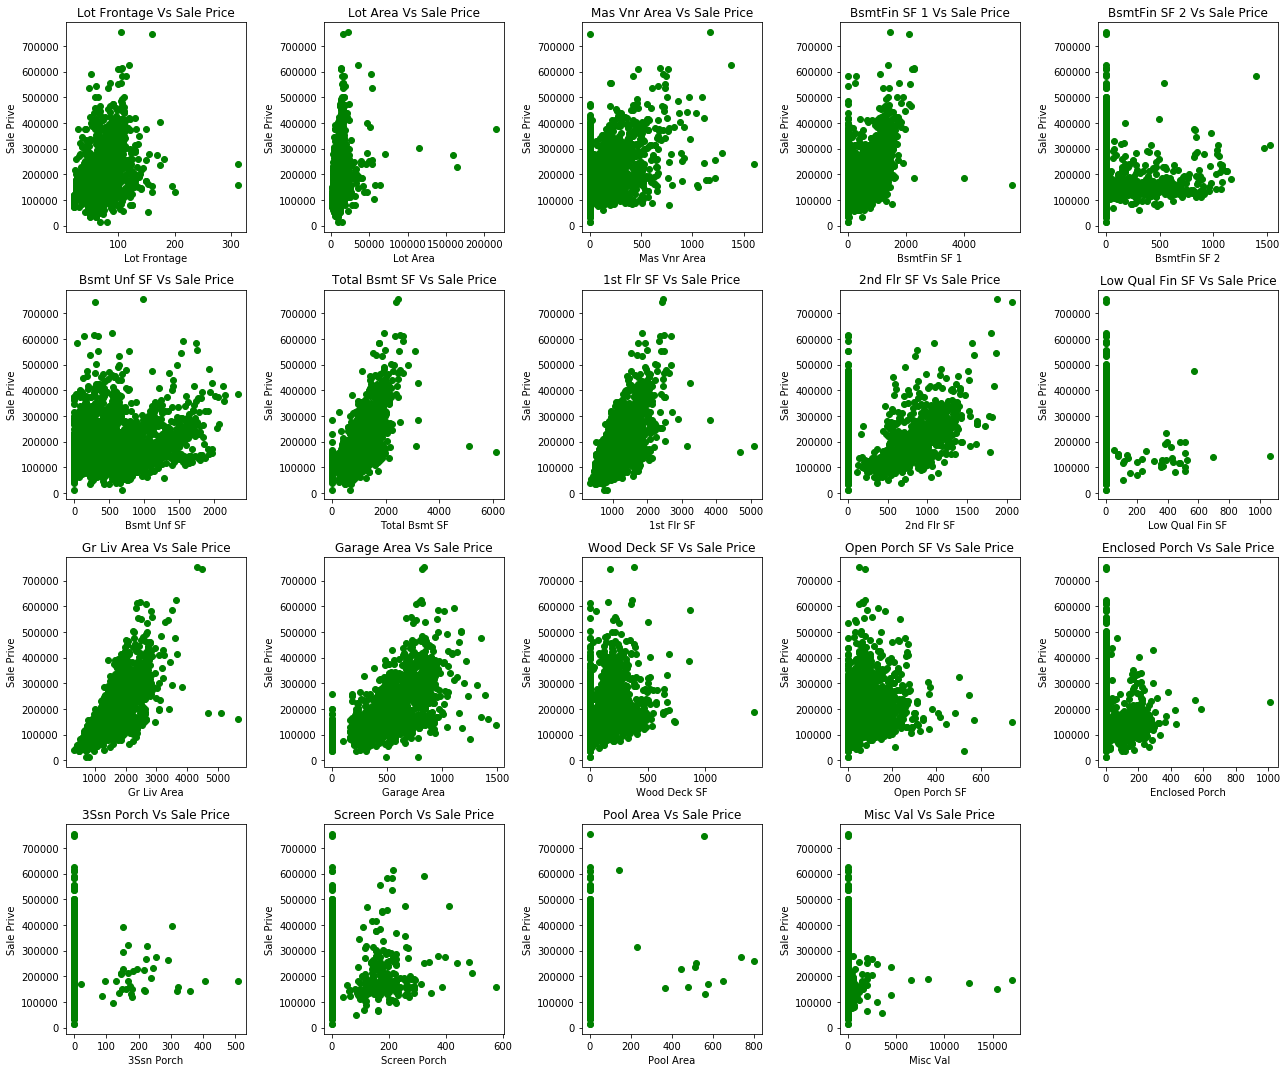

In [39]:
def draw_scatter(data, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,15))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax.scatter(data[var_name],df['SalePrice'],color='green')
        ax.set_title(var_name+" Vs Sale Price")
        ax.set_xlabel(var_name)
        ax.set_ylabel("Sale Prive")
    fig.tight_layout()
    plt.show()

draw_scatter(df.loc[:,cont_var],df.loc[:,cont_var].columns,4,5)

In [40]:
# initializing a linear regression for categorical variable pipeline
linreg_cat = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),('linreg',LinearRegression())])

In [41]:
# creating the train test splits from the data
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,cont_var+cat_var],df['SalePrice'],random_state=42)

In [42]:
# getting cross validation scores for each categorical variable
mean_r2_cat = []
for i in range(0,len(cat_var)):
    mean_r2_cat.append(np.mean(cross_val_score(linreg_cat, X_train.loc[:,cat_var[i]].values.reshape(-1,1), y_train, cv = 5)))

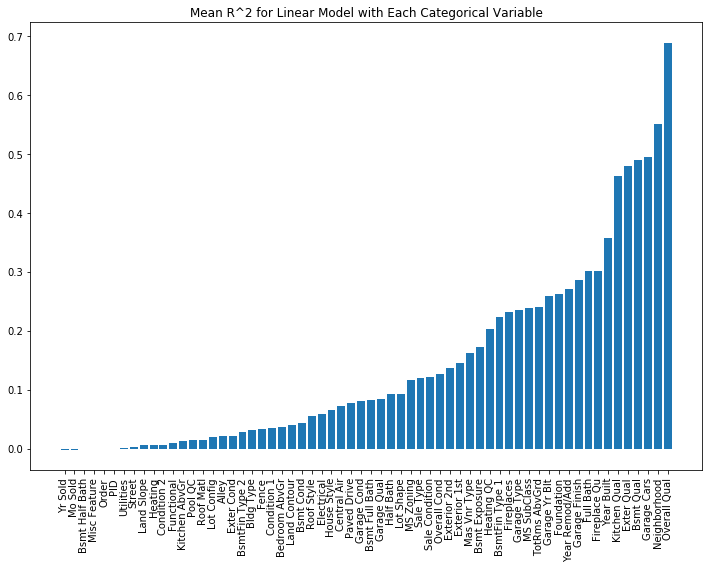

In [43]:
# plotting R^2 as a bar plot

cat_var = [x for _,x in sorted(zip(mean_r2_cat,cat_var))]
mean_r2_cat = sorted(mean_r2_cat)

fig=plt.figure(figsize=(10,8))
plt.bar(range(len(cat_var)), mean_r2_cat)
plt.xticks(range(len(cat_var)), cat_var, rotation=90)
plt.title("Mean R^2 for Linear Model with Each Categorical Variable")
plt.tight_layout()

In [44]:
# initializing a continuous transformer
cont_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

# initializing a categorical transformer
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# initializing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', cont_transformer, cont_var),
        ('cat', cat_transformer, cat_var)])

# appending classifiers and preprocessing pipelines
linreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

ridge = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Ridge())])

lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Lasso(max_iter=5000,tol=0.001))])

enet = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ElasticNet(max_iter=5000, tol=0.001))])

model_name = ['OLS','Ridge','Lasso','ElasticNet']

In [45]:
# Calculating cross validation scores for each
model_scores = []
model_scores.append(np.mean(cross_val_score(linreg, X_train, y_train, cv = 5)))
model_scores.append(np.mean(cross_val_score(ridge, X_train, y_train, cv = 5)))
model_scores.append(np.mean(cross_val_score(lasso, X_train, y_train, cv = 5)))
model_scores.append(np.mean(cross_val_score(enet, X_train, y_train, cv = 5)))

In [46]:
# initializing a continuous transformer
cont_transformer_std = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# initializing column transformer
preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', cont_transformer_std, cont_var),
        ('cat', cat_transformer, cat_var)])

linreg_std = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('classifier', LinearRegression())])

ridge_std = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('classifier', Ridge())])

lasso_std = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('classifier', Lasso(max_iter=5000,tol=0.001))])

enet_std = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('classifier', ElasticNet(max_iter=5000,tol=0.001))])

model_name_std = ['OLS','Ridge','Lasso','ElasticNet']

In [47]:
# Calculating cross validation scores for each
model_scores_std = []
model_scores_std.append(np.mean(cross_val_score(linreg_std, X_train, y_train, cv = 5)))
model_scores_std.append(np.mean(cross_val_score(ridge_std, X_train, y_train, cv = 5)))
model_scores_std.append(np.mean(cross_val_score(lasso_std, X_train, y_train, cv = 5)))
model_scores_std.append(np.mean(cross_val_score(enet_std, X_train, y_train, cv = 5)))

In [48]:
print("Without Standardization")
for i in range(0,4):
    print("The score of %s is %f"% (model_name[i],model_scores[i]))

print("With Standardization")
for i in range(0,4):
    print("The score of %s is %f"% (model_name_std[i],model_scores_std[i]))

Without Standardization
The score of OLS is 0.857337
The score of Ridge is 0.236815
The score of Lasso is 0.865001
The score of ElasticNet is 0.792563
With Standardization
The score of OLS is 0.857712
The score of Ridge is 0.860569
The score of Lasso is 0.865414
The score of ElasticNet is 0.806175


Text(0.5,1,'R^2 With Standardization')

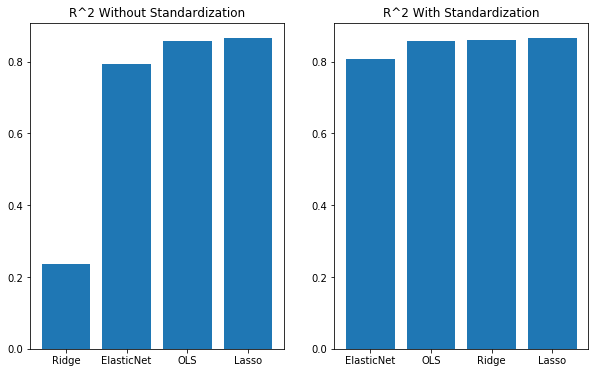

In [49]:
model_name = [x for _,x in sorted(zip(model_scores,model_name))]
model_scores = sorted(model_scores)

model_name_std = [x for _,x in sorted(zip(model_scores_std,model_name_std))]
model_scores_std = sorted(model_scores_std)

fig=plt.figure(figsize=(10,6))

ax=fig.add_subplot(1,2,1)
ax.bar(model_name, model_scores)
ax.set_title("R^2 Without Standardization")

ax=fig.add_subplot(1,2,2)
ax.bar(model_name_std, model_scores_std)
ax.set_title("R^2 With Standardization")

### Observations
 - We observe that with standardization, Lasso continues to produce the best R^2 but the R^2 of Ridge regression is greatly improved and it rises above that of ElasticNet and OLS respectively

In [50]:
# storing parameters for each model
r_param_grid = {'classifier__alpha': np.logspace(-3, 3, 13)}

l_param_grid = {'classifier__alpha': np.logspace(-3, 0, 13)}

e_param_grid = {'classifier__alpha': np.logspace(-4, -1, 10),
              'classifier__l1_ratio': [0.01, .1, .5, .9, .98, 1]}

In [51]:
# performing gridsearch for each model
r_grid = GridSearchCV(ridge_std, r_param_grid, cv=5)
l_grid = GridSearchCV(lasso_std, l_param_grid, cv=5)
e_grid = GridSearchCV(enet_std, e_param_grid, cv=5)

In [ ]:
# fitting all the models
r_grid.fit(X_train, y_train)

l_grid.fit(X_train, y_train)

e_grid.fit(X_train, y_train)

In [ ]:
print("Ridge Best cross-validation score: {:.2f}".format(r_grid.best_score_))
print("Ridge Best parameters: ", r_grid.best_params_)

print("Lasso Best cross-validation score: {:.2f}".format(l_grid.best_score_))
print("Lasso Best parameters: ", l_grid.best_params_)

print("ElasticNet Best cross-validation score: {:.2f}".format(e_grid.best_score_))
print("ElasticNet Best parameters: ", e_grid.best_params_)

In [ ]:
# ridge validation score dependence 


alphas = np.logspace(-3, 3, 13)

train_scores_mean = r_grid.cv_results_["mean_train_score"]
train_scores_std = r_grid.cv_results_["std_train_score"]
test_scores_mean = r_grid.cv_results_["mean_test_score"]
test_scores_std = r_grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Model')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
# plot train scores
plt.semilogx(alphas, train_scores_mean, label='Mean Train score',
             color='navy')
# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(alphas,
                       train_scores_mean - train_scores_std,
                       train_scores_mean + train_scores_std,
                       alpha=0.2,
                       color='navy')
plt.semilogx(alphas, test_scores_mean,
             label='Mean Test score', color='darkorange')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(alphas,
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.legend(loc='best')
plt.show()

In [ ]:
# lasso validation score dependence 


alphas = np.logspace(-3, 0, 13)

train_scores_mean = l_grid.cv_results_["mean_train_score"]
train_scores_std = l_grid.cv_results_["std_train_score"]
test_scores_mean = l_grid.cv_results_["mean_test_score"]
test_scores_std = l_grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Model')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
# plot train scores
plt.semilogx(alphas, train_scores_mean, label='Mean Train score',
             color='navy')
# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(alphas,
                       train_scores_mean - train_scores_std,
                       train_scores_mean + train_scores_std,
                       alpha=0.2,
                       color='navy')
plt.semilogx(alphas, test_scores_mean,
             label='Mean Test score', color='darkorange')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(alphas,
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.legend(loc='best')
plt.show()

In [ ]:
# elacticnet validation score dependence 
res = pd.pivot_table(pd.DataFrame(grid.cv_results_),
    values='mean_test_score', index='param_alpha', columns='param_l1_ratio')

In [ ]:
# Training new models based on gridsearch parameters

ridge_final = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('classifier', Ridge(alpha = r_grid.best_params_))])

lasso_final = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('classifier', Lasso(max_iter=5000, alpha = l_grid.best_params_))])

enet_final = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('classifier', ElasticNet(max_iter=5000, alpha = e_grid.best_params_[0], l1_ratio =  e_grid.best_params_[1] ))])

ridge_final.fit(X_train,y_train)
lasso_final.fit(X_train,y_train)
enet_final.fit(X_train,y_train)

In [ ]:

print("The final score of the  Ridge regression model is: %f" %ridge_final.score(X_test,y_test))
print("The final score of the Lasso regression model model is: %f" %lasso_final.score(X_test,y_test))
print("The final score of the ElasticNet model is: %f" %enet_final.score(X_test,y_test))

In [ ]:
ridge_coeff=dict(zip(cont_var+cat_var, np.concatenate(ridge_final.named_steps.classifier.coef_.reshape(-1,1))))
fig=plt.figure(figsize=(10,4))
plt.bar(range(len(ridge_coeff)), list(ridge_coeff.values()), align='center')
plt.xticks(range(len(ridge_coeff)), list(ridge_coeff.keys()),rotation=90)
plt.title("The Coefficients of Ridge Regeression")
plt.show()

In [ ]:
lasso_coeff=dict(zip(cont_var+cat_var, np.concatenate(lasso_final.named_steps.classifier.coef_.reshape(-1,1))))
fig=plt.figure(figsize=(10,4))
plt.bar(range(len(lasso_coeff)), list(lasso_coeff.values()), align='center')
plt.xticks(range(len(lasso_coeff)), list(lasso_coeff.keys()),rotation=90)
plt.title("The Coefficients of Lasso Regeression")
plt.show()

In [ ]:
elastic_coeff=dict(zip(cont_var+cat_var, np.concatenate(enet_final.named_steps.classifier.coef_.reshape(-1,1))))
fig=plt.figure(figsize=(10,4))
plt.bar(range(len(elastic_coeff)), list(elastic_coeff.values()), align='center')
plt.xticks(range(len(elastic_coeff)), list(elastic_coeff.keys()),rotation=90)
plt.title("The Coefficients of ElasticNet Regeression")
plt.show()